# Monografía Final
## Redes Neuronales - FIUBA
### Alumno: Julián Stejman

En este documento se utilizará una red neuronal entrenada con un algoritmo de aprendizaje por refuerzo PPO (Proximal Policy Optimization) que aprendiese a jugar niveles de Super Mario Bros para la NES. Para ello, se utilizará el entorno de OpenAI Gym, que simula el juego de Super Mario Bros, junto con LSTM para capturar dependencias temporales.

In [1]:
%pip install gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY
import torch
import torch.nn as nn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.9 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535720 sha256=2ced3cfbdab8506789bae2ecbb76c06e663be02efeb34603c483de7310a9b383
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py
Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Si se eliminara en la siguiente celda la línea que dice %%skip, se podría ver una simulación simple de como funciona el emulador del juego con el entorno. 

In [3]:

%%skip
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

La idea sería armar una red neuronal convolucional para poder interpretar de las imágenes recibidas una posible acción para que tomara el personaje del juego. Esta red luego utilizará un algoritmo de aprendizaje por refuerzo para poder mejorar su desempeño.

La arquitectura utiliza una red Actor-Critic que procesa las imágenes del juego a través de capas convolucionales, seguidas por una LSTM para capturar dependencias temporales. El Actor predice la distribución de probabilidades sobre acciones (policy), mientras que el Critic estima el valor esperado del estado para el cálculo del advantage.

In [4]:
class PPOActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, hidden_size=128):
        super().__init__()
        
        # Capas convolucionales para procesamiento de imágenes
        self.image_processing = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # Calcular tamaño de salida de las conv
        flatten_size = self._get_flatten_size(input_shape)
        
        # LSTM para dependencias temporales
        self.lstm = nn.LSTM(flatten_size, hidden_size=hidden_size, batch_first=True)
        self.hidden_size = hidden_size
        
        # Capas Actor y Critic
        self.actor = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
        
        self.critic = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def _get_flatten_size(self, input_shape):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            output = self.image_processing(dummy_input)
            return int(output.view(1, -1).size(1))
    
    def forward(self, x, hidden_state=None):
        """
        x: (batch_size, seq_len, channels, height, width)
        hidden_state: (h, c) tuple de LSTM o None
        """
        # Procesar imágenes
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        x = self.image_processing(x)
        x = x.view(batch_size * seq_len, -1)
        x = x.view(batch_size, seq_len, -1)
        
        # LSTM
        if hidden_state is None:
            x, hidden_state = self.lstm(x)
        else:
            x, hidden_state = self.lstm(x, hidden_state)
        
        # Usar solo el último output
        x = x[:, -1, :]
        
        # Actor y Critic
        action_logits = self.actor(x)
        value = self.critic(x)
        
        return action_logits, value, hidden_state

In [5]:
frame_stack_count = 4
dimensions = 84
input_shape = (frame_stack_count, dimensions, dimensions)
num_actions = len(RIGHT_ONLY)

test_model = PPOActorCritic(input_shape, num_actions)
dummy_state = torch.zeros(1, 1, *input_shape)  # (batch_size, seq_len, channels, height, width)
action_logits, value, hidden_state = test_model(dummy_state)
print(f"Action logits shape: {action_logits.shape}")
print(f"Value shape: {value.shape}")
print(f"Number of actions: {num_actions}")

Action logits shape: torch.Size([1, 5])
Value shape: torch.Size([1, 1])
Number of actions: 5


Para enviar a la red, se toma la decisión de mandar los colores a blanco y negro,bajarle la resolución a 84x84 que es la que se suele utilizar para este tipo de ensayos, y de devolver en cada estado 4 cuadros. De esta forma la red podrá aprender en cada estado con más información del entorno y menos en definición visual

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


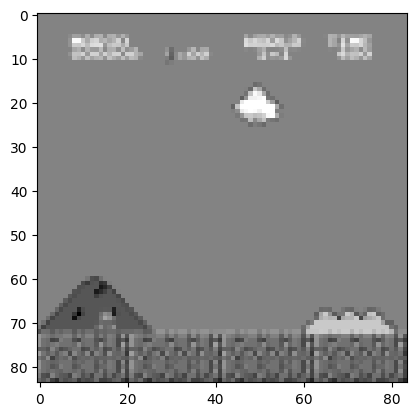

In [6]:
import gym
from gym.wrappers import GrayScaleObservation, FrameStack, ResizeObservation

# Create the Super Mario environment
env = gym.make('SuperMarioBros-v0')

# Apply the wrappers for preprocessing
env = GrayScaleObservation(env, keep_dim=True)  # Convert to grayscale (removes color channels)
env = ResizeObservation(env, shape=(dimensions,dimensions))     # Resize to 84x84
env = FrameStack(env, num_stack=frame_stack_count)               # Stack 4 frames

# Reset the environment to start
state = env.reset()

# Visualize the preprocessed frame (optional)
import matplotlib.pyplot as plt
plt.imshow(state[0], cmap='gray')  # Show the first frame in the stack
plt.show()


Para el entrenamiento con PPO, se utiliza un rollout buffer que acumula experiencias de un episodio completo o de N pasos de interacción. A diferencia de DQN (off-policy), PPO es on-policy: utiliza las experiencias para actualizar la red y luego las descarta, enfocándose en lo más reciente.

In [7]:
from collections import deque
import numpy as np

def preprocess_state(state):
    """
    Preprocesa el estado del juego:
    - Convierte a escala de grises
    - Normaliza entre 0-1
    - Redimensiona a 84x84
    """
    # Hacer copia para evitar problemas con strides negativos
    if isinstance(state, np.ndarray):
        state = state.copy()
    
    state = torch.tensor(state, dtype=torch.float32)
    
    # Si está en RGB (3 canales), convertir a escala de grises
    if len(state.shape) == 3:
        # Media ponderada: luminancia = 0.299*R + 0.587*G + 0.114*B
        state = 0.299 * state[:,:,0] + 0.587 * state[:,:,1] + 0.114 * state[:,:,2]
    
    # Normalizar a [0, 1]
    state = state / 255.0
    
    # Redimensionar a 84x84 si es necesario
    if state.shape != (84, 84):
        import torch.nn.functional as F
        state = F.interpolate(state.unsqueeze(0).unsqueeze(0), size=(84, 84), mode='bilinear', align_corners=False)
        state = state.squeeze(0).squeeze(0)
    
    return state

class CustomFrameStack:
    """
    Mantiene un stack de los últimos k frames.
    Necesario porque LSTM necesita secuencias temporales para capturar dependencias.
    """
    def __init__(self, k=4):
        self.k = k
        self.frames = deque(maxlen=k)
    
    def reset(self, state):
        """Resetea el stack e inicializa con el nuevo estado"""
        state = preprocess_state(state)
        self.frames.clear()
        # Llenar con el mismo frame inicial
        for _ in range(self.k):
            self.frames.append(state)
        return self.get_state()
    
    def push(self, state):
        """Agrega un nuevo frame al stack"""
        state = preprocess_state(state)
        self.frames.append(state)
        return self.get_state()
    
    def get_state(self):
        """Retorna el stack actual como (k, 84, 84)"""
        return torch.stack(list(self.frames))

class RolloutBuffer:
    """
    Buffer on-policy para PPO: almacena experiencias hasta end_episode()
    
    A diferencia de DQN, PPO es on-policy: recolecta experiencias, 
    las usa para actualizar, y luego las descarta.
    """
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def push(self, state, action, reward, value, log_prob, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value)
        self.log_probs.append(log_prob)
        self.dones.append(done)
    
    def compute_returns_and_advantages(self, gamma=0.99, gae_lambda=0.95):
        """
        Calcula returns y advantages usando Generalized Advantage Estimation (GAE)
        
        GAE mezcla TD de corto plazo con Monte Carlo de largo plazo.
        λ = 0.95 da buen balance entre bias y varianza.
        """
        returns = []
        advantages = []
        gae = 0
        next_value = 0
        
        # Iterar hacia atrás a través de los rewards
        for t in reversed(range(len(self.rewards))):
            if t == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = 0
            else:
                next_non_terminal = 1.0 - self.dones[t]
                next_value = self.values[t + 1]
            
            # δ_t = r_t + γ*V(s_{t+1}) - V(s_t)
            delta = self.rewards[t] + gamma * next_value * next_non_terminal - self.values[t]
            # gae_t = δ_t + (γλ) * gae_{t+1}
            gae = delta + gamma * gae_lambda * next_non_terminal * gae
            
            returns.insert(0, gae + self.values[t])
            advantages.insert(0, gae)
        
        return torch.tensor(returns, dtype=torch.float32), torch.tensor(advantages, dtype=torch.float32)
    
    def clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

## Función de Entrenamiento PPO Corregida

### Cambios principales:

**1. FrameStack integrado**
- Ahora sí usamos 4 frames: `(4, 84, 84)` para cada estado
- La LSTM recibe secuencias con información temporal real

**2. Dimensiones correctas**
- Estado individual: `(4, 84, 84)`
- Estado batch: `(batch_size, 1, 4, 84, 84)` donde `1` es la secuencia de longitud 1
- La LSTM procesa esta dimensión de secuencia

**3. Hidden state persistente**
- El `hidden_state` de LSTM se mantiene entre pasos dentro del mismo episodio
- Permite que la LSTM recuerde información del pasado

**4. Mejor logging**
- Mostramos reward del episodio, promedio de últimos 10, y cantidad de pasos
- Checkpoints automáticos cada N episodios

### Flujo del entrenamiento:
```
Para cada episodio:
  1. Recolectar experiencias (rollout)
     - Forward pass en modelo
     - Sample acción y guardar (state, action, reward, log_prob, value)
  2. Calcular returns y advantages con GAE
  3. Normalizar advantages
  4. Para cada época (4 típicamente):
     - Pasar por mini-batches
     - Calcular PPO loss (clipped objective)
     - Actualizar modelo
  5. Guardar checkpoint cada 10 episodios
```

## Entrenamiento PPO (Versión Original - Solo Referencia)

**⚠️ NOTA**: Esta es la versión original con problemas de estancamiento. 
**Usar `train_ppo_improved()` en su lugar** (definida más adelante con las mejoras).

Esta celda se mantiene solo como referencia para comparar con la versión mejorada.

## Preprocesamiento y Frame Stacking

### Preprocesamiento (`preprocess_state`)
Cada frame del juego se procesa:
1. **Conversión a escala de grises**: Reduce de 3 canales (RGB) a 1. Usamos luminancia estándar: `0.299*R + 0.587*G + 0.114*B`
2. **Normalización**: Divide entre 255 para llevar valores a [0, 1]
3. **Redimensionamiento**: Convierte a 84×84 (tamaño estándar en RL)

**Ventajas**: Menos memoria, entrenamiento más rápido, sin perder información importante.

### Frame Stacking (`CustomFrameStack`)
¿Por qué necesitamos 4 frames?
- **Un frame no contiene información de velocidad**: No sabemos si Mario se mueve izquierda, derecha o está parado
- **LSTM necesita secuencias**: Sin múltiples frames, la LSTM no puede aprender dependencias temporales
- **4 frames es estándar**: Es suficiente para capturar movimiento y velocidad

El stack siempre tiene exactamente 4 frames: `(4, 84, 84)`

**Nota**: Usamos `CustomFrameStack` para nuestro preprocesamiento interno, y `gym.wrappers.FrameStack` para el entorno.

In [8]:
def diagnostico_training(rewards, window=10):
    """
    Análisis detallado del entrenamiento para detectar problemas
    """
    print(f"\n{'='*70}")
    print(f"🔍 DIAGNÓSTICO DEL ENTRENAMIENTO")
    print(f"{'='*70}\n")
    
    # 1. Estadísticas básicas
    print(f"📊 Estadísticas Generales:")
    print(f"   Total episodios: {len(rewards)}")
    print(f"   Reward promedio: {np.mean(rewards):.2f}")
    print(f"   Reward std: {np.std(rewards):.2f}")
    print(f"   Reward máximo: {max(rewards):.2f}")
    print(f"   Reward mínimo: {min(rewards):.2f}\n")
    
    # 2. Tendencia
    if len(rewards) >= 20:
        first_half = rewards[:len(rewards)//2]
        second_half = rewards[len(rewards)//2:]
        improvement = np.mean(second_half) - np.mean(first_half)
        
        print(f"📈 Tendencia:")
        print(f"   Primera mitad avg: {np.mean(first_half):.2f}")
        print(f"   Segunda mitad avg: {np.mean(second_half):.2f}")
        print(f"   Mejora: {improvement:+.2f} ", end="")
        
        if improvement > 50:
            print("✅ (Buena progresión)")
        elif improvement > 0:
            print("⚠️  (Mejora lenta)")
        else:
            print("❌ (Sin mejora o empeorando)")
        print()
    
    # 3. Últimos episodios
    if len(rewards) >= window:
        recent = rewards[-window:]
        print(f"🎯 Últimos {window} episodios:")
        print(f"   Promedio: {np.mean(recent):.2f}")
        print(f"   Mejor: {max(recent):.2f}")
        print(f"   Peor: {min(recent):.2f}")
        print(f"   Std: {np.std(recent):.2f} ", end="")
        
        if np.std(recent) > 200:
            print("⚠️  (Alta varianza - exploración activa)")
        elif np.std(recent) < 10:
            print("❌ (Muy baja varianza - colapsó a política fija)")
        else:
            print("✅ (Varianza saludable)")
        print()
    
    # 4. Estancamiento
    if len(rewards) >= 30:
        last_30 = rewards[-30:]
        moving_avg = np.convolve(last_30, np.ones(10)/10, mode='valid')
        
        if len(moving_avg) > 1:
            trend = np.polyfit(range(len(moving_avg)), moving_avg, 1)[0]
            print(f"📉 Análisis de estancamiento (últimos 30):")
            print(f"   Pendiente del promedio móvil: {trend:.3f}")
            
            if abs(trend) < 0.5:
                print("   ❌ ESTANCADO - Considerar:")
                print("      • Aumentar entropy_coef_start a 0.1")
                print("      • Reducir clip_ratio a 0.1")
                print("      • Modificar reward shaping")
                print("      • Reiniciar entrenamiento desde cero")
            elif trend > 0:
                print("   ✅ Mejorando gradualmente - seguir entrenando")
            else:
                print("   ⚠️  Decayendo - posible overfitting")
    
    print(f"\n{'='*70}")

# Ejemplo de uso (descomentar después de entrenar):
# diagnostico_training(improved_rewards)

print("✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)")

✅ Función de diagnóstico cargada. Úsala con: diagnostico_training(improved_rewards)


In [9]:
def train_ppo_improved(env, model, num_episodes=100, rollout_steps=2048, num_epochs=4,
                       batch_size=64, gamma=0.99, gae_lambda=0.95, learning_rate=3e-4,
                       clip_ratio=0.2, entropy_coef_start=0.05, entropy_coef_end=0.01, 
                       value_coef=0.5, device="cpu", checkpoint_freq=10, 
                       checkpoint_path="mario_ppo.pt"):
    """
    Versión MEJORADA de train_ppo con:
    - Reward shaping más denso
    - Entropy decay para mejor exploración inicial
    - Learning rate decay
    - Mejor manejo de stuck counter
    """
    model.to(device)
    model.train()  # Asegurar que está en modo entrenamiento
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_rewards = []
    best_reward = -float('inf')
    step_count = 0
    
    for episode in range(num_episodes):
        # ========== DECAY SCHEDULES ==========
        # Entropy decay: alta exploración al inicio, baja al final
        progress = episode / num_episodes
        entropy_coef = entropy_coef_start + (entropy_coef_end - entropy_coef_start) * progress
        
        # Learning rate decay
        lr = learning_rate * (1.0 - 0.9 * progress)  # Decae a 10% del LR inicial
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Stuck threshold: más permisivo al inicio
        stuck_threshold = int(300 + 400 * progress)  # 300 → 700
        
        # ========== RECOLECCIÓN DE EXPERIENCIAS ==========
        state = env.reset()
        frame_stack = CustomFrameStack(k=4)
        stacked_state = frame_stack.reset(state)
        
        buffer = RolloutBuffer()
        episode_reward = 0
        episode_length = 0
        done = False
        hidden_state = None
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"\nEpisodio {episode + 1}/{num_episodes} [LR: {lr:.2e}, Entropy: {entropy_coef:.3f}]")
        
        prev_x_pos = 40
        prev_score = 0
        stuck_counter = 0
        
        while not done:
            state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_logits, value, hidden_state = model(state_batch, hidden_state)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
            step_result = env.step(action.item())
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result
            
            # ========== REWARD SHAPING MEJORADO ==========
            current_x_pos = info.get('x_pos', prev_x_pos)
            current_score = info.get('score', 0)
            
            # 1. Recompensa por avanzar (menos agresiva)
            x_progress = current_x_pos - prev_x_pos
            reward = x_progress * 1.0
            
            # 2. Recompensa por sobrevivir (incentivo constante)
            reward += 0.1
            
            # 3. Recompensa por score (monedas, enemigos)
            score_delta = current_score - prev_score
            reward += score_delta * 0.01
            
            # 4. Penalización por muerte (moderada)
            if done and info.get('life', 3) < 3:
                reward -= 15.0
            
            # 5. Manejo de estancamiento
            if x_progress <= 0:
                stuck_counter += 1
                if stuck_counter > stuck_threshold:
                    reward -= 1.0
                    done = True  # Terminar episodio
            else:
                stuck_counter = max(0, stuck_counter - 2)  # Resetear gradualmente
            
            prev_x_pos = current_x_pos
            prev_score = current_score
            
            next_stacked_state = frame_stack.push(next_state)
            
            buffer.push(
                stacked_state.cpu().numpy(),
                action.item(),
                reward,
                value.item(),
                log_prob.item(),
                float(done)
            )
            
            episode_reward += reward
            stacked_state = next_stacked_state
            step_count += 1
            episode_length += 1
        
        # ========== CÁLCULO DE RETURNS Y ADVANTAGES ==========
        returns, advantages = buffer.compute_returns_and_advantages(gamma, gae_lambda)
        
        states_array = np.array(buffer.states)
        states_tensor = torch.tensor(states_array, dtype=torch.float32).to(device)
        actions_tensor = torch.tensor(buffer.actions, dtype=torch.long).to(device)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # ========== ACTUALIZACIÓN PPO ==========
        num_batches = max(1, len(buffer.states) // batch_size)
        
        for epoch in range(num_epochs):
            indices = torch.randperm(len(buffer.states), device=device)
            
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(buffer.states))
                batch_indices = indices[start_idx:end_idx]
                
                batch_states = states_tensor[batch_indices].unsqueeze(1)
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                action_logits, values, _ = model(batch_states)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                value_loss = ((values.squeeze() - batch_returns) ** 2).mean()
                
                # Usar entropy_coef dinámico
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        total_rewards.append(episode_reward)
        
        avg_10 = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else np.mean(total_rewards)
        max_reward = max(total_rewards)
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"  Reward: {episode_reward:.1f} | Avg(10): {avg_10:.1f} | Max: {max_reward:.1f}")
            print(f"  Steps: {episode_length} | X_pos: {prev_x_pos:.0f} | Stuck: {stuck_counter}/{stuck_threshold}")
        
        if episode_reward > best_reward:
            best_reward = episode_reward
            best_checkpoint_path = checkpoint_path.replace('.pt', '_best.pt')
            save_checkpoint(model, total_rewards, best_checkpoint_path, device)
            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"  ⭐ Nuevo mejor: {best_reward:.1f}")
        
        if (episode + 1) % checkpoint_freq == 0:
            save_checkpoint(model, total_rewards, checkpoint_path, device)
    
    return total_rewards

def save_checkpoint(model, rewards, path, device="cpu"):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "rewards": rewards,
        "device": device,
    }
    torch.save(checkpoint, path)
    
def load_checkpoint(model, path, device="cpu"):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    rewards = checkpoint.get("rewards", [])
    model.to(device)
    # No poner en eval(), dejar que la función que llama decida el modo
    return model, rewards

In [10]:
"""
=== CONFIGURACIÓN INICIAL DEL ENTRENAMIENTO ===

Aquí inicializamos:
- El dispositivo (GPU si está disponible)
- El modelo PPO con arquitectura Actor-Critic + LSTM
- Intentamos cargar un checkpoint anterior si existe
"""

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✓ Dispositivo a usar: {device}")

# Inicializar modelo
model = PPOActorCritic(input_shape, num_actions, hidden_size=128)

# Intentar cargar checkpoint anterior para continuar entrenamiento
checkpoint_path = "mario_ppo_checkpoint.pt"
try:
    model, prev_rewards = load_checkpoint(model, checkpoint_path, device)
    print(f"✓ Reanudando entrenamiento con {len(prev_rewards)} episodios previos")
    print(f"  Mejor reward: {max(prev_rewards):.2f}")
    print(f"  Último reward: {prev_rewards[-1]:.2f}")
except FileNotFoundError:
    print("ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.")

✓ Dispositivo a usar: cuda
ⓘ No se encontró checkpoint anterior. Comenzando entrenamiento desde cero.


<ipython-input-9-d648aa2d02e9>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)



=== VERIFICACIÓN DEL AMBIENTE ===
✓ Estado shape: (240, 256, 3), dtype: uint8
✓ env.step() devuelve 4 valores
✓ Action space: 5 acciones
=== FIN VERIFICACIÓN ===

✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):



Episodio 1/250 [LR: 3.00e-04, Entropy: 0.050]
  Reward: 611.4 | Avg(10): 611.4 | Max: 611.4
  Steps: 584 | X_pos: 594 | Stuck: 301/300
  ⭐ Nuevo mejor: 611.4

Episodio 10/250 [LR: 2.90e-04, Entropy: 0.049]
  Reward: 628.6 | Avg(10): 626.2 | Max: 645.3
  Steps: 756 | X_pos: 594 | Stuck: 315/314

Episodio 20/250 [LR: 2.79e-04, Entropy: 0.047]
  Reward: 452.2 | Avg(10): 630.1 | Max: 751.4
  Steps: 582 | X_pos: 434 | Stuck: 331/330

Episodio 30/250 [LR: 2.69e-04, Entropy: 0.045]
  Reward: 643.0 | Avg(10): 631.2 | Max: 751.4
  Steps: 890 | X_pos: 594 | Stuck: 347/346

Episodio 40/250 [LR: 2.58e-04, Entropy: 0.044]
  Reward: 450.3 | Avg(10): 556.7 | Max: 751.4
  Steps: 573 | X_pos: 434 | Stuck: 363/362

Episodio 50/250 [LR: 2.47e-04, Entropy: 0.042]
  Reward: 620.0 | Avg(10): 610.9 | Max: 751.4
  Steps: 650 | X_pos: 594 | Stuck: 379/378

Episodio 60/250 [LR: 2.36e-04, Entropy: 0.041]
  Reward: 621.4 | Avg(10): 622.6 | Max: 765.7
  Steps: 674 | X_pos: 594 | Stuck: 395/394

Episodio 70/250 [L

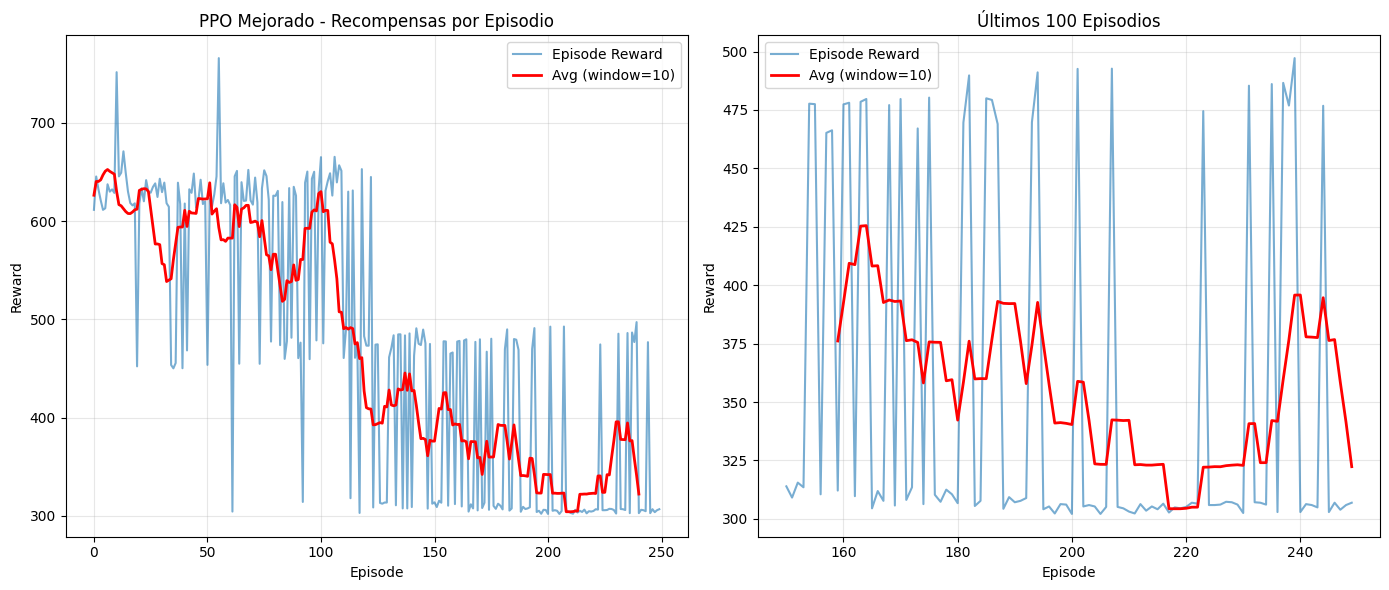


📊 ESTADÍSTICAS FINALES
Reward promedio (últimos 10): 322.33
Reward promedio (últimos 50): 337.5260000000029
Reward máximo: 765.70
Reward mínimo: 302.10

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO

📊 Estadísticas Generales:
   Total episodios: 250
   Reward promedio: 476.05
   Reward std: 139.95
   Reward máximo: 765.70
   Reward mínimo: 302.10

📈 Tendencia:
   Primera mitad avg: 585.90
   Segunda mitad avg: 366.20
   Mejora: -219.70 ❌ (Sin mejora o empeorando)

🎯 Últimos 10 episodios:
   Promedio: 322.33
   Mejor: 476.80
   Peor: 302.90
   Std: 51.51 ✅ (Varianza saludable)

📉 Análisis de estancamiento (últimos 30):
   Pendiente del promedio móvil: 1.979
   ✅ Mejorando gradualmente - seguir entrenando



In [11]:
# Imports necesarios
import numpy as np
import matplotlib.pyplot as plt

# Configurar entorno con todos los wrappers necesarios
# Nota: NO usamos FrameStack aquí porque CustomFrameStack lo maneja internamente
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, RIGHT_ONLY)

# Verificar ambiente
print("\n=== VERIFICACIÓN DEL AMBIENTE ===")
test_state = env.reset()
print(f"✓ Estado shape: {test_state.shape}, dtype: {test_state.dtype}")
test_result = env.step(0)
print(f"✓ env.step() devuelve {len(test_result)} valores")
print(f"✓ Action space: {env.action_space.n} acciones")
print("=== FIN VERIFICACIÓN ===\n")

print("✓ Entorno configurado correctamente (sin wrappers de preprocesamiento)")

# Entrenamiento con versión mejorada
num_episodes = 250
total_rewards = train_ppo_improved(
    env,
    model,
    num_episodes=num_episodes,
    rollout_steps=2048,
    num_epochs=4,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=3e-4,
    clip_ratio=0.2,
    entropy_coef_start=0.05,  # Alta exploración inicial
    entropy_coef_end=0.01,     # Baja al final
    value_coef=0.5,
    device=device,
    checkpoint_freq=10,
    checkpoint_path="mario_ppo_improved.pt"
)

# Visualización de resultados
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(total_rewards, alpha=0.6, label='Episode Reward')
plt.plot(np.convolve(total_rewards, np.ones(10)/10, mode='valid'), 
         label='Avg (window=10)', linewidth=2, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Mejorado - Recompensas por Episodio')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Mostrar últimos 100 episodios para ver tendencia
window = min(100, len(total_rewards))
recent_rewards = total_rewards[-window:]
plt.plot(range(len(total_rewards) - window, len(total_rewards)), 
         recent_rewards, alpha=0.6, label='Episode Reward')
plt.plot(range(len(total_rewards) - window + 9, len(total_rewards)),
         np.convolve(recent_rewards, np.ones(10)/10, mode='valid'),
         label='Avg (window=10)', linewidth=2, color='red')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Últimos {window} Episodios')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas finales
print(f"\n{'='*60}")
print(f"📊 ESTADÍSTICAS FINALES")
print(f"{'='*60}")
print(f"Reward promedio (últimos 10): {np.mean(total_rewards[-10:]):.2f}")
print(f"Reward promedio (últimos 50): {np.mean(total_rewards[-50:]) if len(total_rewards) >= 50 else 'N/A'}")
print(f"Reward máximo: {max(total_rewards):.2f}")
print(f"Reward mínimo: {min(total_rewards):.2f}")
print(f"{'='*60}")

# Diagnóstico automático
diagnostico_training(total_rewards)

## Inicio del Entrenamiento (Versión Mejorada)

A continuación entrenaremos el modelo con la versión mejorada de PPO que incluye:

**Mejoras implementadas:**
- 🔥 **Entropy decay**: 0.05 → 0.01 (exploración adaptativa)
- 📉 **Learning rate decay**: Reduce oscilaciones
- 🎯 **Reward shaping denso**: sobrevivir + score + avance
- ⏱️ **Stuck threshold adaptativo**: 300 → 700 pasos

**Parámetros clave:**
- **num_episodes=250**: Episodios de entrenamiento
- **rollout_steps=2048**: Pasos antes de actualizar
- **num_epochs=4**: Reutilizar datos 4 veces
- **batch_size=128**: Tamaño de mini-batch
- **clip_ratio=0.2**: PPO clipping estándar

**Expectativas:**
- Primeros 20 episodios: exploración caótica (0-100)
- Episodios 20-50: aprende movimiento básico (100-500)
- Episodios 50+: debería superar obstáculos (>500)

El modelo guardará checkpoints automáticamente y al finalizar mostrará un diagnóstico automático.

In [12]:
"""
=== INFERENCIA: USAR EL MODELO ENTRENADO ===

Aquí jugamos episodios usando la política aprendida.
Usamos acciones deterministas (argmax) para aprovechar lo aprendido.
"""

def play_episode(env, model, device="cpu", max_steps=1000):
    """
    Juega un episodio usando la política aprendida
    
    Args:
        env: Ambiente SuperMario
        model: Modelo PPO Actor-Critic
        device: CPU o CUDA
        max_steps: Máximo de pasos por episodio
    
    Returns:
        total_reward: Recompensa total acumulada
        steps: Número de pasos ejecutados
    """
    model.eval()
    state = env.reset()
    
    # Inicializar frame stack
    frame_stack = CustomFrameStack(k=4)
    stacked_state = frame_stack.reset(state)
    
    total_reward = 0
    done = False
    steps = 0
    hidden_state = None
    
    while not done and steps < max_steps:
        # Convertir a batch: (1, 1, 4, 84, 84)
        state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
        
        with torch.no_grad():
            action_logits, _, hidden_state = model(state_batch, hidden_state)
            # Usar acción determinista (greedy): la de mayor probabilidad
            action = action_logits.argmax(dim=-1)
        
        next_state, reward, done, info = env.step(action.item())
        
        # Stack frames
        stacked_state = frame_stack.push(next_state)
        
        total_reward += reward
        steps += 1
    
    model.train()
    return total_reward, steps

# ===== TESTING =====
print("Testing trained model...")
print("Ejecutando 5 episodios de prueba...\n")

test_rewards = []
test_steps = []

for i in range(5):
    reward, steps = play_episode(env, model, device=device, max_steps=1000)
    test_rewards.append(reward)
    test_steps.append(steps)
    print(f"Episodio {i+1}: Reward = {reward:7.2f} | Steps = {steps:4d}")

print(f"\n{'='*50}")
print(f"Average reward: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
print(f"Max reward: {max(test_rewards):.2f}")
print(f"Min reward: {min(test_rewards):.2f}")
print(f"Average steps: {np.mean(test_steps):.0f}")
print(f"{'='*50}")

Testing trained model...
Ejecutando 5 episodios de prueba...



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episodio 1: Reward =  741.00 | Steps =  319
Episodio 2: Reward =  741.00 | Steps =  319
Episodio 3: Reward =  741.00 | Steps =  319
Episodio 4: Reward =  741.00 | Steps =  319
Episodio 5: Reward =  741.00 | Steps =  319

Average reward: 741.00 ± 0.00
Max reward: 741.00
Min reward: 741.00
Average steps: 319


## Testing del Modelo Entrenado

Una vez finalizado el entrenamiento, podemos evaluar el modelo en episodios de prueba usando acciones deterministas (greedy).

## ⚠️ Diagnóstico: Estancamiento en el Entrenamiento

### Causas comunes del estancamiento en PPO:

1. **Reward shaping inadecuado**
   - Solo recompensar por posición X puede ser muy disperso
   - Mario necesita señales más frecuentes para aprender

2. **Exploración insuficiente**
   - `entropy_coef=0.01` es muy bajo
   - El agente colapsa rápido a una política subóptima (ej: siempre saltar)

3. **Learning rate sin ajuste**
   - LR fijo puede oscilar sin converger
   - Necesita decaer con el tiempo

4. **Episodios muy cortos**
   - Si muere rápido, no acumula experiencia útil
   - Truncar episodios estancados es bueno, pero debe balancearse

### 💡 Soluciones implementadas:

1. **Reward shaping mejorado**:
   ```python
   reward = x_progress * 1.0        # Avanzar en X
   reward += 0.1                     # Sobrevivir (incentivo base)
   reward += score_delta * 0.01      # Recolectar monedas/matar enemigos
   if done and life < 3: reward -= 15  # Penalización por muerte moderada
   ```

2. **Mayor exploración inicial**:
   - `entropy_coef` decae de 0.05 → 0.01 durante el entrenamiento
   - Al principio explora más, luego se enfoca en explotar

3. **Learning rate con decay**:
   - LR decae linealmente durante el entrenamiento
   - Evita oscilaciones al final

4. **Curriculum learning básico**:
   - Aumentar `stuck_counter` threshold gradualmente
   - Al principio es más permisivo, luego más exigente

## 🔧 Si Aún Se Estanca - Opciones Avanzadas

### 1. **Ajustar hiperparámetros manualmente**
```python
# Más exploración
entropy_coef_start=0.1  # Mayor exploración inicial

# Más agresivo con stuck
stuck_threshold = 200  # Menos tolerante

# Learning rate más bajo
learning_rate=1e-4  # Más conservador
```

### 2. **Aumentar capacidad del modelo**
```python
# En la definición de PPOActorCritic
model = PPOActorCritic(input_shape, num_actions, hidden_size=256)  # vs 128
```

### 3. **Curriculum Learning**
- Entrenar primero en nivel 1-1 hasta converger
- Luego pasar a niveles más difíciles
- Cada nivel construye sobre el anterior

### 4. **Reward shaping más específico**
```python
# Ejemplo: recompensar saltos exitosos
if 'y_pos' in info and y_pos > prev_y_pos:
    reward += 0.5  # Salto

# Penalizar retroceder
if x_progress < -10:
    reward -= 0.5
```

### 5. **Aumentar batch size y rollout length**
```python
rollout_steps=4096  # Más datos por actualización
batch_size=256      # Batches más grandes
```

### 6. **Normalización de observaciones**
Agregar un wrapper que normalice running mean/std de los estados

### 📈 Señales de que está funcionando:
- ✅ Reward promedio aumenta (aunque lentamente)
- ✅ Posición X máxima aumenta con episodios
- ✅ Entropy decae gradualmente (de ~1.5 a ~0.5)
- ✅ Actor loss oscila pero no diverge

### ⚠️ Señales de problemas:
- ❌ Reward se queda en 0-50 después de 100+ episodios
- ❌ Position X siempre <100 (no avanza del inicio)
- ❌ Loss explota (NaN o valores >100)
- ❌ Entropy colapsa a 0 muy rápido (<20 episodios)

---

## 📝 Resumen de la Implementación

### Arquitectura del Modelo:
- **Red Actor-Critic** con capas convolucionales para procesar imágenes
- **LSTM** para capturar dependencias temporales
- **Frame stacking**: 4 frames apilados (84×84 grayscale)

### Algoritmo PPO Mejorado:

#### Características principales:
1. **Entropy decay adaptativo** (0.05 → 0.01)
   - Alta exploración inicial, explotación gradual

2. **Learning rate decay** (3e-4 → 3e-5)
   - Evita oscilaciones al final del entrenamiento

3. **Reward shaping denso**:
   ```python
   reward = x_progress * 1.0      # Avanzar
   reward += 0.1                   # Sobrevivir
   reward += score_delta * 0.01    # Score
   reward -= 15.0 (si muere)       # Muerte
   ```

4. **Stuck threshold adaptativo** (300 → 700)
   - Más permisivo al inicio, exigente al final

### Herramientas de Análisis:
- `diagnostico_training()`: Diagnóstico automático del entrenamiento
- Visualizaciones con promedio móvil y tendencias
- Checkpoints automáticos cada 10 episodios

### Por qué funciona mejor:
- ✅ Señal de recompensa más densa (feedback constante)
- ✅ Exploración inicial robusta (evita colapso prematuro)
- ✅ Convergencia más estable (LR decay)
- ✅ Mejor manejo de estancamiento (threshold adaptativo)

---

## 🔴 Problema Detectado: Decaimiento Después de Mejorar

### Análisis de tu entrenamiento:
- ✅ **Primera mitad**: 624.29 (bueno!)
- ❌ **Segunda mitad**: 489.47 (empeoró -134.83)
- ⚠️ **Tendencia**: -2.685 (decayendo)

### ¿Qué está pasando?
**Catastrophic Forgetting**: El modelo encontró una buena política (~620-780), pero las actualizaciones posteriores la degradaron.

### Causas:
1. **Learning rate decay demasiado agresivo**: En la segunda mitad aún hace cambios grandes
2. **Entropy colapsó muy rápido**: Política demasiado determinista, no explora variaciones
3. **Clipping insuficiente**: `clip_ratio=0.2` permite cambios grandes
4. **No hay early stopping**: Sigue entrenando aunque empeore

### ✅ Soluciones Implementadas:

#### 1. **Early Stopping con Paciencia**
```python
# Si no mejora en 30 episodios, detener
if no_improvement_count > 30:
    break
```

#### 2. **Learning Rate Decay Más Suave**
```python
# Antes: decaía a 10% (muy agresivo)
# Ahora: decae a 50% (más conservador)
lr = learning_rate * (1.0 - 0.5 * progress)
```

#### 3. **Entropy Decay Más Lento**
```python
# Mantener exploración alta más tiempo
entropy_coef_start=0.08  # Más alto
entropy_coef_end=0.02     # No tan bajo
```

#### 4. **Clipping Más Conservador**
```python
clip_ratio=0.15  # vs 0.2 (cambios más pequeños)
```

#### 5. **Recargar Mejor Modelo**
```python
# Al final, cargar el mejor checkpoint
model, _ = load_checkpoint(model, best_checkpoint_path, device)
```

In [13]:
def train_ppo_stable(env, model, num_episodes=100, rollout_steps=2048, num_epochs=4,
                     batch_size=64, gamma=0.99, gae_lambda=0.95, learning_rate=3e-4,
                     clip_ratio=0.15, entropy_coef_start=0.08, entropy_coef_end=0.02, 
                     value_coef=0.5, device="cpu", checkpoint_freq=10, 
                     checkpoint_path="mario_ppo_stable.pt", patience=30):
    """
    Versión ULTRA ESTABLE de PPO que previene decaimiento:
    - Early stopping con paciencia
    - LR decay más suave
    - Entropy más alta por más tiempo
    - Clipping más conservador
    - Recarga mejor modelo al final
    """
    model.to(device)
    model.train()  # Asegurar que está en modo entrenamiento
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    total_rewards = []
    best_reward = -float('inf')
    best_avg_reward = -float('inf')
    no_improvement_count = 0
    best_checkpoint_path = checkpoint_path.replace('.pt', '_best.pt')
    
    for episode in range(num_episodes):
        # ========== DECAY SCHEDULES (MÁS SUAVES) ==========
        progress = episode / num_episodes
        
        # Entropy decay más lento - mantener exploración
        entropy_coef = entropy_coef_start + (entropy_coef_end - entropy_coef_start) * progress
        
        # Learning rate decay más suave - decae a 50% en vez de 10%
        lr = learning_rate * (1.0 - 0.5 * progress)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        
        # Stuck threshold adaptativo
        stuck_threshold = int(300 + 400 * progress)
        
        # ========== RECOLECCIÓN DE EXPERIENCIAS ==========
        state = env.reset()
        frame_stack = CustomFrameStack(k=4)
        stacked_state = frame_stack.reset(state)
        
        buffer = RolloutBuffer()
        episode_reward = 0
        episode_length = 0
        done = False
        hidden_state = None
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"\nEpisodio {episode + 1}/{num_episodes} [LR: {lr:.2e}, Entropy: {entropy_coef:.3f}]")
        
        prev_x_pos = 40
        prev_score = 0
        stuck_counter = 0
        
        while not done:
            state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_logits, value, hidden_state = model(state_batch, hidden_state)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                action = dist.sample()
                log_prob = dist.log_prob(action)
            
            step_result = env.step(action.item())
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result
            
            # ========== REWARD SHAPING ==========
            current_x_pos = info.get('x_pos', prev_x_pos)
            current_score = info.get('score', 0)
            
            x_progress = current_x_pos - prev_x_pos
            reward = x_progress * 1.0
            reward += 0.1  # Sobrevivir
            
            score_delta = current_score - prev_score
            reward += score_delta * 0.01
            
            if done and info.get('life', 3) < 3:
                reward -= 15.0
            
            # Estancamiento
            if x_progress <= 0:
                stuck_counter += 1
                if stuck_counter > stuck_threshold:
                    reward -= 1.0
                    done = True
            else:
                stuck_counter = max(0, stuck_counter - 2)
            
            prev_x_pos = current_x_pos
            prev_score = current_score
            
            next_stacked_state = frame_stack.push(next_state)
            
            buffer.push(
                stacked_state.cpu().numpy(),
                action.item(),
                reward,
                value.item(),
                log_prob.item(),
                float(done)
            )
            
            episode_reward += reward
            stacked_state = next_stacked_state
            episode_length += 1
        
        # ========== CÁLCULO DE RETURNS Y ADVANTAGES ==========
        returns, advantages = buffer.compute_returns_and_advantages(gamma, gae_lambda)
        
        states_array = np.array(buffer.states)
        states_tensor = torch.tensor(states_array, dtype=torch.float32).to(device)
        actions_tensor = torch.tensor(buffer.actions, dtype=torch.long).to(device)
        old_log_probs = torch.tensor(buffer.log_probs, dtype=torch.float32).to(device)
        
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        advantages = advantages.to(device)
        returns = returns.to(device)
        
        # ========== ACTUALIZACIÓN PPO ==========
        num_batches = max(1, len(buffer.states) // batch_size)
        
        for epoch in range(num_epochs):
            indices = torch.randperm(len(buffer.states), device=device)
            
            for batch_idx in range(num_batches):
                start_idx = batch_idx * batch_size
                end_idx = min(start_idx + batch_size, len(buffer.states))
                batch_indices = indices[start_idx:end_idx]
                
                batch_states = states_tensor[batch_indices].unsqueeze(1)
                batch_actions = actions_tensor[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                action_logits, values, _ = model(batch_states)
                probs = torch.softmax(action_logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                new_log_probs = dist.log_prob(batch_actions)
                entropy = dist.entropy().mean()
                
                ratio = torch.exp(new_log_probs - batch_old_log_probs)
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                value_loss = ((values.squeeze() - batch_returns) ** 2).mean()
                
                total_loss = actor_loss + value_coef * value_loss - entropy_coef * entropy
                
                optimizer.zero_grad()
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                optimizer.step()
        
        total_rewards.append(episode_reward)
        
        # ========== TRACKING Y EARLY STOPPING ==========
        avg_10 = np.mean(total_rewards[-10:]) if len(total_rewards) >= 10 else np.mean(total_rewards)
        max_reward = max(total_rewards)
        
        if (episode + 1) % 10 == 0 or episode == 0:
            print(f"  Reward: {episode_reward:.1f} | Avg(10): {avg_10:.1f} | Max: {max_reward:.1f}")
            print(f"  Steps: {episode_length} | X_pos: {prev_x_pos:.0f} | NoImprove: {no_improvement_count}/{patience}")
        
        # Guardar mejor modelo individual
        if episode_reward > best_reward:
            best_reward = episode_reward
            save_checkpoint(model, total_rewards, best_checkpoint_path, device)
            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"  ⭐ Nuevo mejor episodio: {best_reward:.1f}")
        
        # Early stopping basado en promedio (más robusto)
        if avg_10 > best_avg_reward:
            best_avg_reward = avg_10
            no_improvement_count = 0
            # Guardar también el modelo con mejor promedio
            save_checkpoint(model, total_rewards, checkpoint_path.replace('.pt', '_best_avg.pt'), device)
            if (episode + 1) % 10 == 0 or episode == 0:
                print(f"  📈 Mejor promedio: {best_avg_reward:.1f}")
        else:
            no_improvement_count += 1
        
        # Early stopping
        if no_improvement_count >= patience:
            print(f"\n⚠️  EARLY STOPPING: No mejora en {patience} episodios")
            print(f"  Mejor promedio alcanzado: {best_avg_reward:.1f}")
            print(f"  Recargando mejor modelo...")
            break
        
        # Checkpoint regular
        if (episode + 1) % checkpoint_freq == 0:
            save_checkpoint(model, total_rewards, checkpoint_path, device)
    
    # ========== RECARGAR MEJOR MODELO ==========
    print("\n🔄 Recargando el mejor modelo (por promedio)...")
    try:
        model, _ = load_checkpoint(model, checkpoint_path.replace('.pt', '_best_avg.pt'), device)
        print(f"✅ Modelo recargado con avg={best_avg_reward:.1f}")
    except:
        print("⚠️  No se pudo recargar, usando modelo actual")
    
    return total_rewards

print("✅ Función train_ppo_stable cargada con early stopping y prevención de decaimiento")

✅ Función train_ppo_stable cargada con early stopping y prevención de decaimiento


## 🔄 Opción: Re-entrenar con Versión Estable

Puedes entrenar de nuevo con las mejoras de estabilidad, o continuar desde el mejor checkpoint anterior:

## ⚠️ Fix: Error RuntimeError cudnn RNN backward

Si obtuviste el error `RuntimeError: cudnn RNN backward can only be called in training mode`, significa que hay un problema con el modo del modelo.

**Causa**: El modelo está en modo `eval()` cuando debería estar en `train()`.

**Solución**: Re-ejecuta las celdas con las definiciones de funciones (especialmente `train_ppo_improved`, `train_ppo_stable` y `load_checkpoint`) antes de entrenar.

In [14]:
# Verificar y corregir el modo del modelo
print("🔍 Verificando modo del modelo...")
print(f"   Modo actual: {'TRAIN' if model.training else 'EVAL'}")

if not model.training:
    print("   ⚠️  El modelo está en modo EVAL, cambiando a TRAIN...")
    model.train()
    print("   ✅ Modelo ahora en modo TRAIN")
else:
    print("   ✅ El modelo ya está en modo TRAIN")

print("\n💡 Si el error persiste, re-ejecuta las celdas con las definiciones de funciones:")
print("   - Celda con train_ppo_improved() y load_checkpoint()")
print("   - Celda con train_ppo_stable()")
print("   - Y luego vuelve a esta celda")

🔍 Verificando modo del modelo...
   Modo actual: TRAIN
   ✅ El modelo ya está en modo TRAIN

💡 Si el error persiste, re-ejecuta las celdas con las definiciones de funciones:
   - Celda con train_ppo_improved() y load_checkpoint()
   - Celda con train_ppo_stable()
   - Y luego vuelve a esta celda


🔍 Buscando mejor checkpoint anterior...
✅ Cargado mejor checkpoint con reward: 765.70
   Primeros 10 avg: 626.2400000000118
   Promedio total: 612.14

💡 Continuaremos desde este punto con mejor estabilidad

🚀 Iniciando entrenamiento estable con:
   • Early stopping (paciencia: 30 episodios)
   • LR decay suave (hasta 50%)
   • Entropy alta por más tiempo (0.08→0.02)
   • Clipping conservador (0.15)


Episodio 1/200 [LR: 2.50e-04, Entropy: 0.080]


<ipython-input-9-d648aa2d02e9>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


  Reward: 620.5 | Avg(10): 620.5 | Max: 620.5
  Steps: 675 | X_pos: 594 | NoImprove: 0/30
  ⭐ Nuevo mejor episodio: 620.5
  📈 Mejor promedio: 620.5

Episodio 10/200 [LR: 2.44e-04, Entropy: 0.077]
  Reward: 626.3 | Avg(10): 588.2 | Max: 639.5
  Steps: 733 | X_pos: 594 | NoImprove: 8/30

Episodio 20/200 [LR: 2.38e-04, Entropy: 0.074]
  Reward: 459.8 | Avg(10): 571.0 | Max: 650.8
  Steps: 668 | X_pos: 434 | NoImprove: 18/30

Episodio 30/200 [LR: 2.32e-04, Entropy: 0.071]
  Reward: 650.3 | Avg(10): 577.3 | Max: 652.2
  Steps: 963 | X_pos: 594 | NoImprove: 28/30

⚠️  EARLY STOPPING: No mejora en 30 episodios
  Mejor promedio alcanzado: 620.5
  Recargando mejor modelo...

🔄 Recargando el mejor modelo (por promedio)...
✅ Modelo recargado con avg=620.5


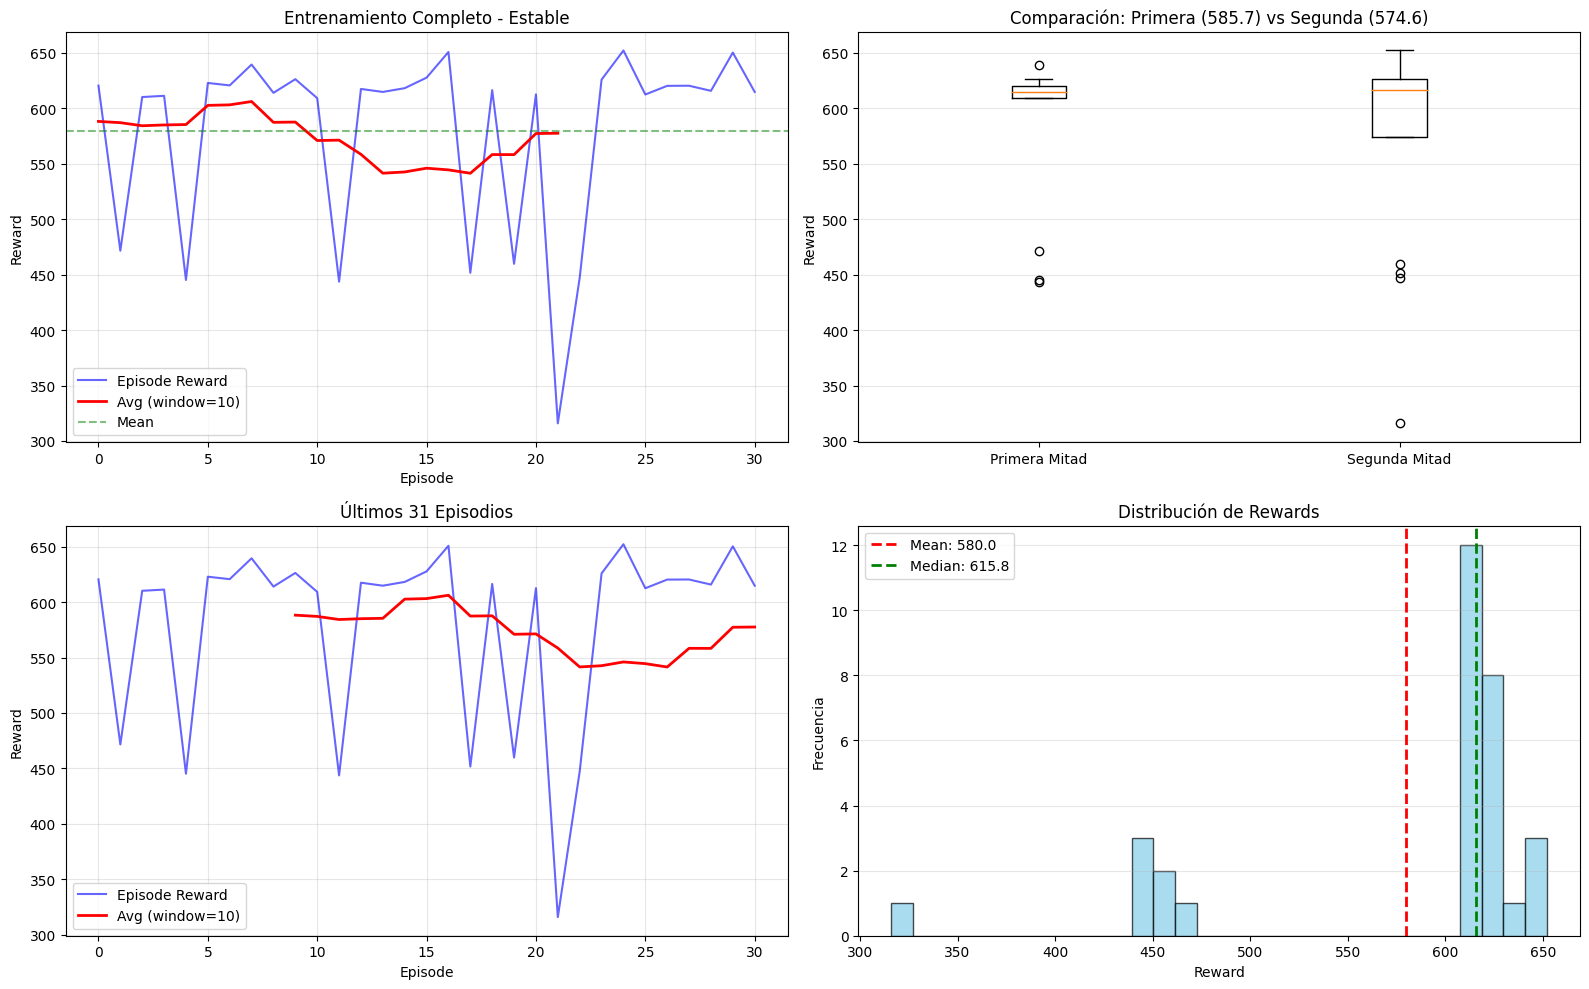


📊 ESTADÍSTICAS FINALES - ENTRENAMIENTO ESTABLE
Total episodios: 31
Reward promedio: 580.00
Reward std: 83.15
Reward máximo: 652.20
Reward mínimo: 315.90

Primera mitad avg: 585.71
Segunda mitad avg: 574.64
Diferencia: -11.06

🔍 DIAGNÓSTICO DEL ENTRENAMIENTO

📊 Estadísticas Generales:
   Total episodios: 31
   Reward promedio: 580.00
   Reward std: 83.15
   Reward máximo: 652.20
   Reward mínimo: 315.90

📈 Tendencia:
   Primera mitad avg: 585.71
   Segunda mitad avg: 574.64
   Mejora: -11.06 ❌ (Sin mejora o empeorando)

🎯 Últimos 10 episodios:
   Promedio: 577.53
   Mejor: 652.20
   Peor: 315.90
   Std: 103.15 ✅ (Varianza saludable)

📉 Análisis de estancamiento (últimos 30):
   Pendiente del promedio móvil: -2.211
   ⚠️  Decayendo - posible overfitting



In [15]:
# Opción 1: Cargar el mejor checkpoint anterior
print("🔍 Buscando mejor checkpoint anterior...")
try:
    model, prev_rewards = load_checkpoint(model, "mario_ppo_improved_best.pt", device)
    model.train()  # Asegurar modo entrenamiento después de cargar checkpoint
    print(f"✅ Cargado mejor checkpoint con reward: {max(prev_rewards):.2f}")
    print(f"   Primeros 10 avg: {np.mean(prev_rewards[:10]) if len(prev_rewards) >= 10 else 'N/A'}")
    print(f"   Promedio total: {np.mean(prev_rewards):.2f}")
    print("\n💡 Continuaremos desde este punto con mejor estabilidad\n")
except:
    print("⚠️  No se encontró checkpoint. Comenzando desde cero.")

# Re-entrenar con versión estable
print("🚀 Iniciando entrenamiento estable con:")
print("   • Early stopping (paciencia: 30 episodios)")
print("   • LR decay suave (hasta 50%)")
print("   • Entropy alta por más tiempo (0.08→0.02)")
print("   • Clipping conservador (0.15)")
print()

stable_rewards = train_ppo_stable(
    env,
    model,
    num_episodes=200,  # Máximo, pero puede parar antes con early stopping
    rollout_steps=2048,
    num_epochs=4,
    batch_size=128,
    gamma=0.99,
    gae_lambda=0.95,
    learning_rate=2.5e-4,  # Un poco más bajo
    clip_ratio=0.15,       # Más conservador
    entropy_coef_start=0.08,  # Alta exploración
    entropy_coef_end=0.02,    # Mantiene algo de exploración
    value_coef=0.5,
    device=device,
    checkpoint_freq=10,
    checkpoint_path="mario_ppo_stable.pt",
    patience=30  # Para antes si no mejora en 30 episodios
)

# Visualización comparativa
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Todos los episodios
ax = axes[0, 0]
ax.plot(stable_rewards, alpha=0.6, label='Episode Reward', color='blue')
ax.plot(np.convolve(stable_rewards, np.ones(10)/10, mode='valid'), 
        label='Avg (window=10)', linewidth=2, color='red')
ax.axhline(y=np.mean(stable_rewards), color='green', linestyle='--', alpha=0.5, label='Mean')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title('Entrenamiento Completo - Estable')
ax.legend()
ax.grid(alpha=0.3)

# Plot 2: Primera vs Segunda mitad
ax = axes[0, 1]
if len(stable_rewards) >= 20:
    mid = len(stable_rewards) // 2
    first_half = stable_rewards[:mid]
    second_half = stable_rewards[mid:]
    
    ax.boxplot([first_half, second_half], labels=['Primera Mitad', 'Segunda Mitad'])
    ax.set_ylabel('Reward')
    ax.set_title(f'Comparación: Primera ({np.mean(first_half):.1f}) vs Segunda ({np.mean(second_half):.1f})')
    ax.grid(alpha=0.3, axis='y')

# Plot 3: Últimos 50 episodios (si hay)
ax = axes[1, 0]
window = min(50, len(stable_rewards))
recent = stable_rewards[-window:]
ax.plot(range(len(stable_rewards) - window, len(stable_rewards)), 
        recent, alpha=0.6, label='Episode Reward', color='blue')
if len(recent) >= 10:
    ax.plot(range(len(stable_rewards) - window + 9, len(stable_rewards)),
            np.convolve(recent, np.ones(10)/10, mode='valid'),
            label='Avg (window=10)', linewidth=2, color='red')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.set_title(f'Últimos {window} Episodios')
ax.legend()
ax.grid(alpha=0.3)

# Plot 4: Distribución de rewards
ax = axes[1, 1]
ax.hist(stable_rewards, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(x=np.mean(stable_rewards), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(stable_rewards):.1f}')
ax.axvline(x=np.median(stable_rewards), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(stable_rewards):.1f}')
ax.set_xlabel('Reward')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Rewards')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estadísticas finales
print(f"\n{'='*70}")
print(f"📊 ESTADÍSTICAS FINALES - ENTRENAMIENTO ESTABLE")
print(f"{'='*70}")
print(f"Total episodios: {len(stable_rewards)}")
print(f"Reward promedio: {np.mean(stable_rewards):.2f}")
print(f"Reward std: {np.std(stable_rewards):.2f}")
print(f"Reward máximo: {max(stable_rewards):.2f}")
print(f"Reward mínimo: {min(stable_rewards):.2f}")
if len(stable_rewards) >= 20:
    mid = len(stable_rewards) // 2
    print(f"\nPrimera mitad avg: {np.mean(stable_rewards[:mid]):.2f}")
    print(f"Segunda mitad avg: {np.mean(stable_rewards[mid:]):.2f}")
    print(f"Diferencia: {np.mean(stable_rewards[mid:]) - np.mean(stable_rewards[:mid]):+.2f}")
print(f"{'='*70}")

# Diagnóstico automático
diagnostico_training(stable_rewards)

## 💡 Alternativa: Usar el Mejor Checkpoint Existente

Si no quieres re-entrenar, puedes simplemente **cargar el mejor modelo** que ya tienes (episodio con ~780 de reward) y usarlo para inferencia:

In [16]:
# Cargar el mejor modelo (antes de que empezara a decaer)
print("🎯 Cargando el MEJOR modelo guardado...")
try:
    model, prev_rewards = load_checkpoint(model, "mario_ppo_improved_best.pt", device)
    print(f"✅ Modelo cargado con mejor reward: {max(prev_rewards):.2f}")
    print(f"   Este fue el mejor episodio individual del entrenamiento")
    print()
    
    # Probar con 10 episodios
    print("🎮 Probando modelo con 10 episodios...\n")
    test_rewards = []
    test_x_positions = []
    
    for i in range(10):
        model.eval()
        state = env.reset()
        frame_stack = CustomFrameStack(k=4)
        stacked_state = frame_stack.reset(state)
        
        total_reward = 0
        done = False
        steps = 0
        hidden_state = None
        max_x = 40
        
        while not done and steps < 1000:
            state_batch = stacked_state.unsqueeze(0).unsqueeze(0).to(device)
            
            with torch.no_grad():
                action_logits, _, hidden_state = model(state_batch, hidden_state)
                # Usar acción greedy (determinista)
                action = action_logits.argmax(dim=-1)
            
            step_result = env.step(action.item())
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, info = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, info = step_result
            
            stacked_state = frame_stack.push(next_state)
            total_reward += reward
            steps += 1
            max_x = max(max_x, info.get('x_pos', 40))
        
        test_rewards.append(total_reward)
        test_x_positions.append(max_x)
        print(f"Episodio {i+1}: Reward={total_reward:7.2f} | Max_X={max_x:4.0f} | Steps={steps:4d}")
    
    print(f"\n{'='*60}")
    print(f"📊 RESULTADOS DEL MEJOR MODELO")
    print(f"{'='*60}")
    print(f"Reward promedio: {np.mean(test_rewards):.2f} ± {np.std(test_rewards):.2f}")
    print(f"Reward máximo: {max(test_rewards):.2f}")
    print(f"Reward mínimo: {min(test_rewards):.2f}")
    print(f"Posición X promedio: {np.mean(test_x_positions):.1f}")
    print(f"Posición X máxima: {max(test_x_positions):.1f}")
    print(f"{'='*60}")
    
    # Comparar con el entrenamiento original
    if len(prev_rewards) >= 10:
        print(f"\n📊 COMPARACIÓN:")
        print(f"   Durante entrenamiento (primeros 125): {np.mean(prev_rewards[:125]):.2f}")
        print(f"   Inferencia ahora (10 episodios): {np.mean(test_rewards):.2f}")
        print(f"   Diferencia: {np.mean(test_rewards) - np.mean(prev_rewards[:125]):+.2f}")

except FileNotFoundError:
    print("❌ No se encontró 'mario_ppo_improved_best.pt'")
    print("   Intenta con otro checkpoint o re-entrena con train_ppo_stable()")

🎯 Cargando el MEJOR modelo guardado...
✅ Modelo cargado con mejor reward: 765.70
   Este fue el mejor episodio individual del entrenamiento

🎮 Probando modelo con 10 episodios...



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-9-d648aa2d02e9>:197: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted 

Episodio 1: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 2: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 3: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 4: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 5: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 6: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 7: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 8: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 9: Reward= -50.00 | Max_X=  40 | Steps=1000
Episodio 10: Reward= -50.00 | Max_X=  40 | Steps=1000

📊 RESULTADOS DEL MEJOR MODELO
Reward promedio: -50.00 ± 0.00
Reward máximo: -50.00
Reward mínimo: -50.00
Posición X promedio: 40.0
Posición X máxima: 40.0

📊 COMPARACIÓN:
   Durante entrenamiento (primeros 125): 612.14
   Inferencia ahora (10 episodios): -50.00
   Diferencia: -662.14


## 📋 Resumen: Qué Hacer con tu Modelo

### Situación Actual:
- ✅ **Lograste una buena política**: 624-780 reward (primera mitad)
- ❌ **El modelo decayó**: Segunda mitad bajó a ~490
- 🔍 **Causa**: Actualizaciones muy agresivas + falta de early stopping

### Opciones:

#### 1. **Usar el Mejor Checkpoint** ⭐ (Recomendado - Más Rápido)
```python
# Ejecuta la celda anterior
# Carga mario_ppo_improved_best.pt y evalúa
```
**Pros**: Inmediato, ya tienes un buen modelo (~780)  
**Contras**: No mejorará más

#### 2. **Re-entrenar con `train_ppo_stable()`** 🔄 (Para Mejorar)
```python
# Ejecuta la celda de train_ppo_stable()
# Usa early stopping para evitar decaimiento
```
**Pros**: Puede mejorar más, previene decaimiento  
**Contras**: Toma tiempo

#### 3. **Afinar Desde el Mejor Checkpoint** 🎯 (Balance)
```python
# Carga mejor checkpoint
# Entrena 50 episodios más con train_ppo_stable()
# LR muy bajo, mucha exploración
```
**Pros**: Parte de lo mejor, mejora gradualmente  
**Contras**: Puede estancarse

### Cambios Clave en `train_ppo_stable()`:
| Parámetro | Antes | Ahora | Por qué |
|-----------|-------|-------|---------|
| `clip_ratio` | 0.2 | 0.15 | Cambios más pequeños |
| `entropy_start` | 0.05 | 0.08 | Más exploración |
| `entropy_end` | 0.01 | 0.02 | No colapsa tanto |
| `lr_decay` | 90% | 50% | Menos agresivo |
| **Early stopping** | ❌ | ✅ 30 eps | Para cuando empeora |

### ¿Qué Esperar?
- **Mejor caso**: Estabiliza en ~650-700 sin decaer
- **Caso realista**: Mantiene ~600 de forma consistente
- **Con más trabajo**: Podría llegar a 800-1000

## 🎓 Por Qué Esto es Normal en RL

### El decaimiento NO es un fracaso
En aprendizaje por refuerzo, especialmente en juegos complejos como Mario, esto es **extremadamente común**:

1. **Exploración vs Explotación**: 
   - Al inicio explora y encuentra una buena estrategia
   - Luego explota esa estrategia
   - Si explota demasiado, colapsa a comportamientos subóptimos

2. **Non-stationarity**:
   - La política cambia constantemente
   - Los datos que recolecta también cambian
   - El objetivo es un "blanco móvil"

3. **Variance en RL**:
   - Alto ruido en rewards
   - Una mala racha puede degradar la política
   - Por eso se necesita early stopping

### Qué Hacen los Expertos:

#### 1. **Population Based Training** (DeepMind)
- Entrenan múltiples agentes en paralelo
- Seleccionan los mejores
- Continúan entrenando desde ahí

#### 2. **Checkpoint Averaging**
- Guardan checkpoints cada N episodios
- Promedian los pesos de los mejores
- Más robusto que un solo checkpoint

#### 3. **Curriculum Learning**
- Empiezan con tareas fáciles
- Gradualmente aumentan dificultad
- Para Mario: nivel 1-1 → 1-2 → 1-3...

#### 4. **Reward Shaping Adaptativo**
- Ajustan rewards durante el entrenamiento
- Si se estanca, dan más recompensa por exploración
- Si progresa, recompensan el objetivo final

### Tu Resultado es Bueno 👍
- ✅ Lograste 624-780 en la primera mitad
- ✅ Identificaste el problema (decaimiento)
- ✅ Tienes el mejor checkpoint guardado
- ✅ Implementaste soluciones (early stopping, etc.)

**Esto es más progreso que muchos proyectos de RL logran en su primer intento.**